# Sweeps in 1000 genomes male X haplotypes

In [1]:
import os, sys, math, re
from pathlib import Path
import numpy
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

numpy.random.seed(7)

/home/kmt/anaconda2/envs/simons/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


Import variables global to the entire analysis:

In [2]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [3]:
if str(ag.scripts_dir) not in sys.path:
    sys.path.append(str(ag.scripts_dir))

from hg19_chrom_sizes import hg19_chrom_sizes

Plotting setup:

In [4]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # seaborn niceness
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

Ignore warnings:

In [5]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)

### Load data

In [13]:

df_list = list()

for chrom in ['X', '2']:

    for tup in ag.g1000_pop_info.itertuples():
    
    
    
        #####################################
        if not tup.population == 'CHB':
            continue
        #####################################
        
        dir_path = ag.steps_dir / '1000genomes' / 'male_dist_admix_masked_stores' / chrom / tup.population / '5-e05'
        print(dir_path)
        for path in dir_path.glob('sweep_data_*.hdf'):
            dist_cut, clade_cut = map(float, re.search(r'sweep_data_([^_]+)_([^_]+)%.hdf', path.name).groups())
            clade_cut /= 100
            df = pd.read_hdf(path)
            df['dist_cut'] = dist_cut
            df['clade_cut'] = clade_cut
            df['chrom'] = chrom
            df['population'] = tup.population
            df['superpop'] = tup.superpop
            df_list.append(df)
    
sweep_data = pd.concat(df_list)

sweep_data['superpop'] = pd.Categorical(sweep_data.superpop, 
                                        categories=['AFR', 'EUR', 'SAS', 'EAS', 'AMR'], 
                                        ordered=True)
sweep_data.head()


ValueError: No objects to concatenate

In [9]:
subset_df = sweep_data.loc[(sweep_data.dist_cut == 5e-5) & (sweep_data.chrom == 'X') & (sweep_data.population == 'CHB')]

In [12]:
def get_best_sweep_call(grp):

    if grp.swept.sum():
        return grp.loc[(grp.swept == True) & (grp.clade_cut == grp.clade_cut.max())]
    else:
        return grp.loc[grp.clade_cut == grp.clade_cut.min()]

df = subset_df.groupby(['chrom', 'population', 'start']).apply(get_best_sweep_call).reset_index(drop=True)
df.head()


,indiv_1,start,end,mean_dist,mean_dist_af,prop_indivs_missing,win_swept,win_swept_af,called,called_af,...,run_length,swept,run_id_af,run_length_af,swept_af,dist_cut,clade_cut,chrom,population,superpop
0,NA18530,0,100000,NaN,NaN,1.0,True,True,False,False,...,22,False,1,22,False,0.00005,0.0,X,CHB,EAS
1,NA18534,0,100000,NaN,NaN,1.0,True,True,False,False,...,22,False,1,22,False,0.00005,0.0,X,CHB,EAS
2,NA18536,0,100000,NaN,NaN,1.0,True,True,False,False,...,22,False,1,22,False,0.00005,0.0,X,CHB,EAS
3,NA18543,0,100000,NaN,NaN,1.0,True,True,False,False,...,22,False,1,22,False,0.00005,0.0,X,CHB,EAS
4,NA18544,0,100000,NaN,NaN,1.0,True,True,False,False,...,22,False,1,22,False,0.00005,0.0,X,CHB,EAS


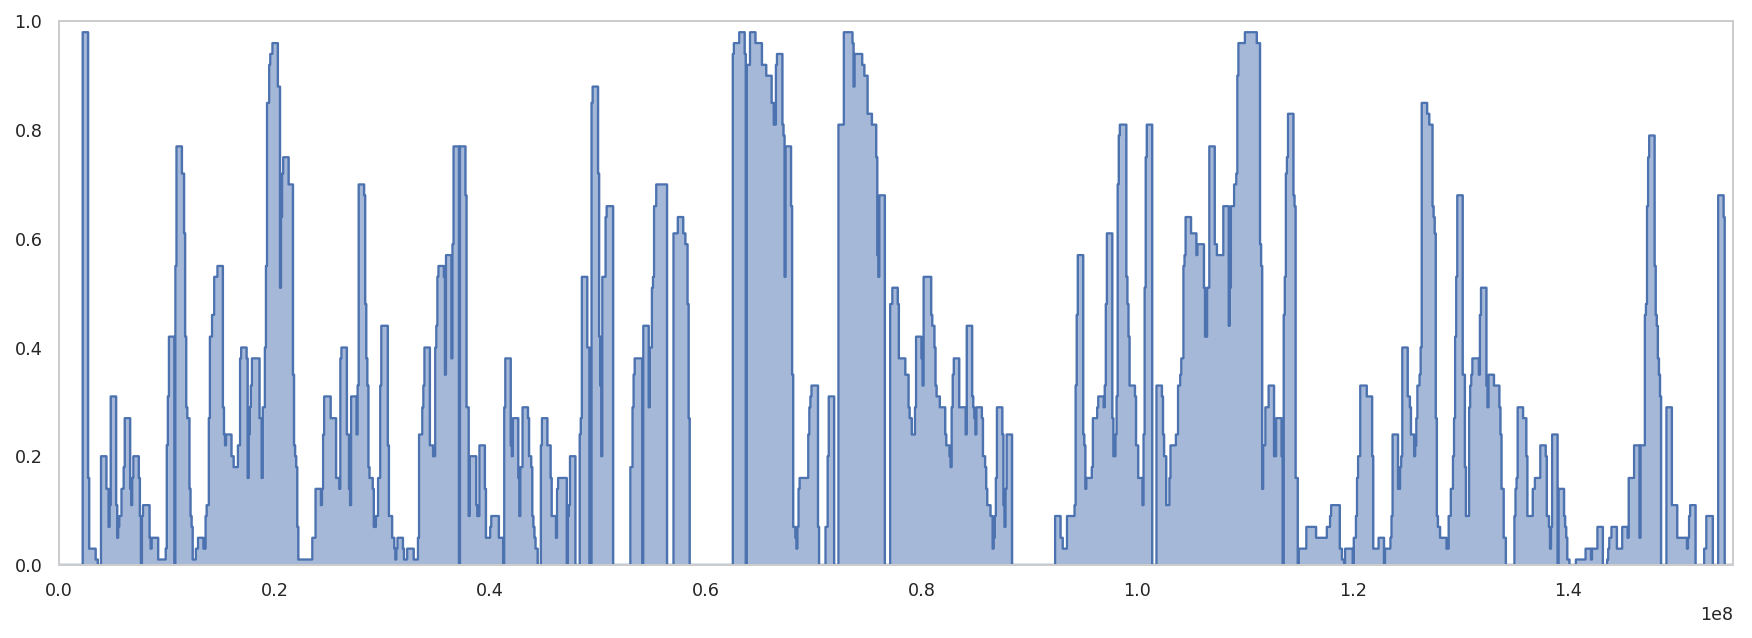

In [10]:
def filter_func(grp):

    cols = ['chrom', 'population', 'start', 'end', 'clade_cut']
    
    df = grp.loc[grp.swept == True]
    if not len(df):
        return grp.loc[grp.clade_cut == grp.clade_cut.min(), cols].iloc[0]
    return df.loc[df.clade_cut == df.clade_cut.max(), cols].iloc[0]

test_df = subset_df.groupby(['chrom', 'population', 'start']).apply(filter_func).reset_index(drop=True)


with sns.axes_style("whitegrid", {'axes.grid' : False}):

    fig, ax = plt.subplots(1, 1, figsize=(15, 5),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})
    
    df = stairs(test_df)
    ax.plot(df.pos, df.clade_cut)
    ax.fill_between(df.pos, df.clade_cut, alpha=0.5)



... shows the proportion of individuals that across 500kb has a mutual distance below cutoff.

In [ ]:
plot_df = (subset_df
           .groupby(['chrom', 'clade_cut', 'start', 'end', 'superpop', 'population'])['swept']
           .aggregate(['sum', 'size'])
           .rename(columns={'sum': 'nr_swept', 'size': 'total'})
           .reset_index()
           .assign(prop_swept=lambda df: df.nr_swept / df.total)
          )
plot_df.head()

In [ ]:
colormap = matplotlib.cm.get_cmap('PuRd', 100)

n_subplots = sweep_data.clade_cut.unique().size

from mpl_toolkits.axes_grid1 import make_axes_locatable


with sns.axes_style("whitegrid", {'axes.grid' : False}):

    fig, ax = plt.subplots(1, 1, figsize=(15, 5),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})
#     ax.set_facecolor('black')
    
    for clade_cut, call_df in plot_df.groupby('clade_cut'):
        
#         if clade_cut < 0.5:
#             continue

        df = stairs(call_df)
        ax.fill_between(df.pos, df.prop_swept, color=colormap(clade_cut), linewidth=0.0)

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="2%", pad=0.25)    
    cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=colormap, orientation='vertical')
    plt.gcf().add_axes(ax_cb)

    plt.tight_layout()



In [ ]:
n_subplots = sweep_data.clade_cut.unique().size

with sns.axes_style("whitegrid", {'axes.grid' : False}):

    fig, axes = plt.subplots(n_subplots, 1, sharey=True, sharex=True, figsize=(15, 100),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})

    for ax, (clade_cut, call_df) in zip(axes, plot_df.groupby('clade_cut')):
        
        ax.set_title("{:.0f}%".format(clade_cut*100), loc='left', fontsize=10)

        df = call_df.copy()
        df.loc[df.prop_swept < clade_cut, 'prop_swept'] = 0

        df = stairs(df)
        ax.plot(df.pos, df.prop_swept, label='population')
        ax.legend(loc='upper right')

        ax.axhline(clade_cut, color='black', linestyle='dashed')
        
    plt.tight_layout()


In [ ]:
df_list = list()
for chrom in ['X']:
    for tup in ag.g1000_pop_info.itertuples():
        df = pd.read_hdf(ag.steps_dir / '1000genomes' / \
                'male_dist_admix_masked_stores' / chrom / tup.population / 'sweep_data_5e-05_30%.hdf')
        df['chrom'] = chrom
        df['population'] = tup.population
        df['superpop'] = tup.superpop
        df_list.append(df)
    
sweep_data = pd.concat(df_list)

sweep_data['superpop'] = pd.Categorical(sweep_data.superpop, 
                                        categories=['AFR', 'EUR', 'SAS', 'EAS', 'AMR'], 
                                        ordered=True)
sweep_data.head()

# Mask for missing data and PARs and add columns such as never_swept...

In [ ]:
ag.g1000_pop_info.style.set_properties(**{'text-align': 'left'})

## Missing regions

## Stats on sweeps

In [ ]:
sr = sweep_data.groupby('population').apply(lambda df: df.indiv_1.unique().size)
sns.barplot(sr, sr.index)


## Proportion swept

In [ ]:
# group by start, end, region and compute size
plot_df = (sweep_data
           .groupby(['start', 'end', 'superpop', 'population'])['swept']
           .aggregate(['sum', 'size'])
           .rename(columns={'sum': 'nr_swept', 'size': 'total'})
           .reset_index()
           .assign(prop_swept=lambda df: df.nr_swept / df.total)
          )
plot_df.head()

In [ ]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, axes = plt.subplots(5, 1, sharey=True, figsize=(15, 15),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})

    for ax, (superpop, super_df) in zip(axes, plot_df.groupby('superpop')):
        ax.set_title(superpop, loc='left', fontsize=8)

        for (population, pop_df) in super_df.groupby('population'):
            df = stairs(pop_df)
            ax.plot(df.pos, df.prop_swept, label=population)
        ax.legend(loc='upper right')

    plt.tight_layout()
plt.savefig(str(ag.figures_dir / "g1000_ech.pdf"))

In [ ]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, axes = plt.subplots(26, 1, sharey=True, figsize=(13, 50),                      
                             subplot_kw={'xlim':(0, hg19_chrom_sizes['chrX']),
                                         'ylim':(0, 1)})
    for ax, population in zip(axes, ag.g1000_pop_info.population):
        df = stairs(plot_df.loc[plot_df.population == population])
        ax.plot(df.pos, df.prop_swept)
        ax.set_title(population, loc='left', fontsize=8)
    plt.tight_layout()

    

In [ ]:
with sns.axes_style("whitegrid", {'axes.grid' : False}):
    fig, axes = plt.subplots(26, 1, sharex=True, sharey=True, figsize=(10, 10),                         
                             subplot_kw={'xlim':(0, chromosome_lengths['X']),
                                         'ylim':(0, 1)})

    for ax, population in zip(axes, g1000_populations):
        df = plot_df.loc[plot_df.population == population]    
        
        for tup in df.itertuples():
            if tup.nr_swept:
                g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, tup.nr_swept/tup.total, 
#                                  facecolor=region_colors[reg], 
                                 linewidth=0,
                                 #edgecolor=None,#region_colors[reg], 
                                 zorder=2))
        ax.set_title(reg, loc='left')
                
        for tup in missing_regions.loc[missing_regions.is_missing == True].itertuples():
            g = ax.add_patch(Rectangle((tup.start, 0), tup.end-tup.start, 1, 
                     facecolor='lightgray', 
                     linewidth=0,
#                     edgecolor=None,
                     alpha=0.5,
                     zorder=1))
    #     ax.set_ylim(0, df.nr_swept.max())

    plt.tight_layout()
    
    plt.savefig(str(figures_dir / "tot_swept_by_region.pdf"))
    #plt.close() # closing teh plot suppres automatic plotting without plt.show()